# Gini Coefficient

**Gini Coefficient:** A performance metric for binary classification models.

## Set Up

### Import Packages

In [1]:
# Packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# my packages
import cap
import confusion
import gini

### Constants and Parameters

In [2]:
# constants
RANDOM_SEED = 42

# plotting defaults
sns.set_theme()
sns.set(font_scale=1.1)

### Generate Sample Data

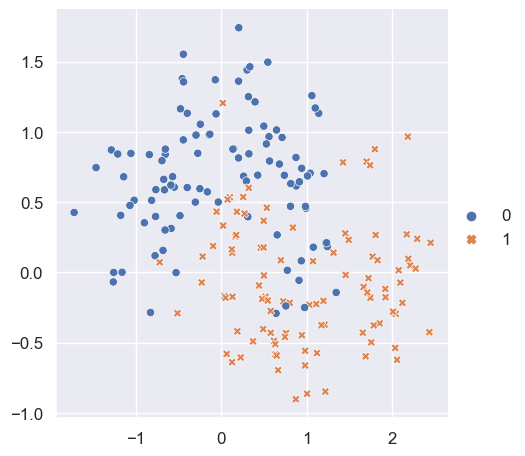

In [3]:
# generate sample data - 2 interleaving half circles
X, y = make_moons(n_samples=200, noise=0.3, random_state=RANDOM_SEED)

sns.relplot(x=X[:, 0], y=X[:, 1], hue=y, style=y);

### Sample Models

In [4]:
# train random forest classifier
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)
forest_clf.fit(X, y)

y_pred = forest_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

Training Accuracy: 0.97


In [5]:
# train logistic regression
log_reg = LogisticRegression()
log_reg.fit(X, y)

y_pred = log_reg.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

Training Accuracy: 0.83


## Somers' D

### Summary?

**Kendall Rank Correlation Coefficient:** (or *Kendall's $\tau$ Coefficient*) A measure of *ordinal association* between two random variables
- Between -1 and 1
- For a sample, $\tau$ will be high when observations have a similar rank (relative position in a sample)

---

Take a sample $(\mathbf{x}, \mathbf{y})=(x_1, y_1),\ldots, (x_n, y_n)$ of observations of a pair $X, Y$ of random variables.

### Concordance

A pair of observations $(x_i, y_i)$ and $(x_j, y_j)$ with $i<j$ are *concordant* if the $x$s and $y$s have the same relative position; that is, if
- $x_i < x_j$ and $y_i < y_j$; or
- $x_i > x_j$ and $y_i > y_j$.

They are called *discordant* if:
- $x_i < x_j$ and $y_i > y_j$; or
- $x_i > x_j$ and $y_i < y_j$.

If $x_i=x_j$ or $y_i=y_j$ they are neither concordanct or discordant.

### Kendell's $\tau$ Coefficient

#### For Samples

The *Kendall Rank Correlation Coefficient* or *Kendall's $\tau$ Coefficient* for a sample $(\mathbf{x}, \mathbf{y})$

\begin{equation}
    \tau = \tau(\mathbf{x}, \mathbf{y}) = \frac{n_c - n_d}{\binom{n}{2}}
\end{equation}

where $n_c$ and $n_d$ are the number of concordant and discordant pairs, respectively (and $\binom{n}{2}=\frac{n(n-1)}{2}$ is the total number of pairs).

**Note:** This is sometimes called 'Tau-a' to distinguish from variants that make adjustments for ties.

A more explicit formulation is

\begin{equation}
     \tau(\mathbf{x}, \mathbf{y}) = \frac{2}{n(n-1)} \sum_{i<j} \text{sgn}(x_i - x_j)~\text{sgn}(y_i - y_j),
\end{equation}

where we set $\text{sgn}(0)=0$.

**Properties**
- $\tau$ takes values between -1 and 1
- $\tau = 1$ if the agreement between the two rankings is perfect
- $\tau = -1$ if the disagreement between the two rankings is perfect

##### Example

From the plot above, clearly there is negative rank correlations between $x_1$ and the binary output.

In [6]:
# my implementation of kendalls tau-a
gini.kendalls_tau(y, X[:, 1])

-0.38402010050251256

There's an implementation of Kendall's $\tau$ in `scipy.stats`, but this is the 'b' or 'c' which rescale to [-1, 1] taking ties into account. It performs a significance for independence with the statistic as an attribute.

In [7]:
# kendalls tau-b
stats.kendalltau(y, X[:, 1], variant="b").statistic

-0.5417270168673702

#### For Distributions

Following the explicit formulation, we define Kendall's $\tau$ for $(X, Y)$ as

\begin{align}
     \tau(X, Y) 
         & = E\big(\text{sgn}(X_1 - X_2) \cdot \text{sgn}(Y_1 - Y_2)\big) \\
         & = P\big(\text{sgn}(X_1 - X_2) = \text{sgn}(Y_1 - Y_2)\big) 
             - P\big(\text{sgn}(X_1 - X_2) \neq \text{sgn}(Y_1 - Y_2)\big),
\end{align}

where $(X_1, Y_1)$ and $(X_2, Y_2)$ are independent bivariate random variables with the sample distributions as $(X, Y)$.

**Properties**
- If $X$ and $Y$ are independent then $\tau(X, Y)=0$
- $\tau(X, X) = P\left( X_1\neq X_2\right)$, so if $X$ is continuous then $\tau(X, X)=1$, otherwise (if $X$ has point masses) $\tau(X, X) < 1$

#### For Binary Variables

Suppose that $X$ and $Y$ are binary variables. Then we can rewrite

\begin{align}
    \tau(X, Y) 
        & = P\big((X_1=0, X_2=1, Y_1=0, Y_2=1)\cup(X_1=1, X_2=0, Y_1=1, Y_2=0)\big) \\
        & \qquad - P\big((X_1=0, X_2=1, Y_1=1, Y_2=0)\cup(X_1=1, X_2=0, Y_1=0, Y_2=1)\big) \\
        & = 2\big[ P\left(X_1=0, X_2=1, Y_1=0, Y_2=1\right) - P\left(X_1=0, X_2=1, Y_1=1, Y_2=0\right)\big] \\
        & = 2\big[ P\left(X_1=0, Y_1=0\right) \cdot P\left(X_2=1, Y_2=1\right) 
            - P\left(X_1=0, Y_1=1\right) \cdot P\left(X_2=1, Y_2=0\right)\big] \\
        & = 2\big[ P\left(X=0, Y=0\right) \cdot P\left(X=1, Y=1\right) - P\left(X=0, Y=1\right) \cdot P\left(X=1, Y=0\right)\big].
\end{align}

In particular,

\begin{equation}
    \tau(X, X) = 2P\left( X=0 \right) \cdot P\left( X=1 \right).
\end{equation}

#### Hypothesis Testing

Kendall's $\tau$ can be used as a test statistic for the hypothesis that two variables $X$ and $Y$ are independent. Under the null hypothesis, the sampling distribution of $\tau = \tau(X, Y)$ has

\begin{equation}
    \text{E}\left(\tau\right) = 0, \qquad \text{Var}\left(\tau\right) = \frac{2(2n+5)}{9n(n-1)}.
\end{equation}

For small samples ($n\leq 10$), the distribution of $\tau$ can be calculated exactly and hypothesis testing can be conducted using statistical tests. For larger samples, $\tau$ is approximately normal (with expectation and variance above), so the following test statistic is approximately standard normal:

\begin{equation}
    z = \tau \sqrt{\frac{9n(n-1)}{2(2n+5)}}.
\end{equation}

There are variants that take into account ties.

##### Example

Again, `scipy.stats` has an implementation for hypothesis tests (with the 'b' or 'c' variant). 

In [8]:
# test hypothesis that x0 and x1 have no rank association
stats.kendalltau(X[:, 0], X[:, 1], variant="b", alternative="two-sided").pvalue

7.511637783175901e-07

We would reject the null hypothesis of independence under any reasonable standard.

### Somers' D

#### For Samples

Define *Somers' D* of $\mathbf{y}$ with respect to $\mathbf{x}$ by

\begin{equation}
    D_{\mathbf{y}\mathbf{x}} = \frac{\tau(\mathbf{x}, \mathbf{y})}{\tau(\mathbf{x}, \mathbf{x})}.
\end{equation}

Note that pairs in $(\mathbf{x}, \mathbf{x})$ are never discordant - $(x_i, x_i)$ and $(x_j, x_j)$ are concordant if and only if $x_i\neq x_j$. So $D_{\mathbf{y}\mathbf{x}}$ is simply $n_c-n_d$ over the number of unequal pairs in $\mathbf{x}$.

**Properties**
- Unlike $\tau$, $D_{\mathbf{y}\mathbf{x}}$ *isn't* symmetric in $\mathbf{x}$ and $\mathbf{y}$

##### Example

Since `X[:, 1]` has no ties, Somers' D equals Kendall's Tau:

In [9]:
# my implementation of somers' d
somers_d = gini.somers_d(y, X[:, 1])
print(somers_d.round(4))

-0.384


Swapping the arguments, the value changes:

In [10]:
somers_d = gini.somers_d(X[:, 1], y)
print(somers_d.round(4))

-0.7642


There's an implementation of Somers' D in `scipy.stats`. As with Kendall's $\tau$ it automatically performs a significance test (the test is slightly different - it tests for $D=0$, not full independence).

**Note that the order of the arguments is reversed.**

In [11]:
# scipy.stats implementation
stats.somersd(y, X[:, 1]).statistic

-0.7642

#### For Distributions

Define Somers' D of $Y$ with respect to $X$ by

\begin{equation}
    D_{YX} = \frac{E\big(\text{sgn}(X_1 - X_2) \cdot \text{sgn}(Y_1 - Y_2)\big)}{P(X_1\neq X_2)}.
\end{equation}

Using the probability formulation of Kendall's $\tau$ gives

\begin{align}
    D_{YX} 
        & = \frac{P\big(\text{sgn}(X_1 - X_2) = \text{sgn}(Y_1 - Y_2)\big) 
            - P\big(\text{sgn}(X_1 - X_2) \neq \text{sgn}(Y_1 - Y_2)\big)}{P(X_1\neq X_2)} \\
        & = P\big(\text{sgn}(X_1 - X_2) = \text{sgn}(Y_1 - Y_2) \,\big|\, X_1\neq X_2 \big) 
            - P\big(\text{sgn}(X_1 - X_2) \neq \text{sgn}(Y_1 - Y_2) \,\big|\, X_1\neq X_2 \big).
\end{align}

Note that $X$ is continuous then this coincides with Kendall's $\tau$.

#### For Binary Variables

If $X$ and $Y$ are binary variables then, using the binary formulation of Kendall's $\tau$,

\begin{align}
    D_{YX}
        & = P(Y=1 \,|\, X=1) \cdot P(Y=0 \,|\, X=0) - P(Y=1 \,|\, X=0) \cdot P(Y=0 \,|\, X=1) \\
        & = P(Y=1 \,|\, X=1) \big( 1 - P(Y=1 \,|\, X=0)\big) - P(Y=1 \,|\, X=0) \big( 1- P(Y=1 \,|\, X=1)\big) \\
        & = P(Y=1 \,|\, X=1) - P(Y=1 \,|\, X=0).
\end{align}

#### Gini Coefficient

Suppose that $Y$ is a binary random variable and $\hat{Y}$ is an estimator of $Y$ - either a binary predictor or $[0, 1]$-valued prediction probabilities. (We could also take some relevant feature we wish to investigate in place of $\hat{Y}$).

**Definition:** The *Gini Coefficient* of $Y$ with respect to $\hat{Y}$ is $D_{\hat{Y}Y}$.

Note the order of $Y$ and $\hat{Y}$.

In particular, if $\hat{Y}$ is a binary output then

\begin{align}
    D_{\hat{Y}Y} 
        & = P(\hat{Y}=1 \,|\, Y=1) - P(\hat{Y}=1 \,|\, Y=0) \\ 
        & = (\text{True Positive Rate}) - (\text{False Positive Rate}).
\end{align}

##### Example

We can evaluate the logistic regression and random forest models.

In [12]:
# evaluate logistic regression - my implementation
y_prob = log_reg.predict_proba(X)[:, 1]
gini_coefficient = gini.gini_coefficient(y_pred=y_prob, y_true=y)

print(gini_coefficient.round(4))

0.8556


In [13]:
# for random forest
y_prob = forest_clf.predict_proba(X)[:, 1]
gini_coefficient = gini.gini_coefficient(y_pred=y_prob, y_true=y)

print(gini_coefficient.round(4))

0.997


Of course you can also use `scipy.stats.somersd`, but you need to be careful with the order of the arguments.

We can also calculate Gini for binary precictions.

In [14]:
# gini for binary predictions
y_pred = forest_clf.predict(X)
gini_coefficient = gini.gini_coefficient(y_pred=y_pred, y_true=y)

print(gini_coefficient.round(4))

0.95


We can verify that this equals the different between the true positive and false negative rates.

In [15]:
true_positive_rate = confusion.get_true_positive_rate(y_pred=y_pred, y_true=y)
false_positive_rate = confusion.get_false_positive_rate(y_pred=y_pred, y_true=y)

gini_coefficient = true_positive_rate - false_positive_rate
print(gini_coefficient)

0.95


## Cumulative Accuracy Profile (CAP) Curve

Consider a binary classification problem. We have targets $\mathbf{y}=(y_1, \ldots, y_n)$ and a model that generates predicted probabilities $\mathbf{\hat{p}} = (\hat{p}_1, \ldots, \hat{p}_n)$. Order the samples such that $\hat{p}_1 \geq \cdots \geq \hat{p}_n$. Let $n_+$ and $n_-$ denote the number of positive and negative labels in $\mathbf{y}$, respectively.

We generate a binary predictions by choosing a threshold $t$ and setting

\begin{equation}
    \hat{y} = \begin{cases}
        1 & \quad \text{if } \hat{p} \geq t \\
        0 & \quad \text{if } \hat{p} < t.
    \end{cases}
\end{equation}

For a given threshold, let

\begin{equation}
    k = \big| \lbrace i \,\mid\, \hat{p}_i \geq t \rbrace \big|,\qquad 
    k_+ = \big| \lbrace i \,\mid\, \hat{p}_i \geq t, y_i=1 \rbrace\big|, \qquad
    k_- = \big| \lbrace i \,\mid\, \hat{p}_i \geq t, y_i=0 \rbrace\big|.
\end{equation}

So $k$ is the number of samples we classify as positive, $k_+$ is the number of true positives, and $k_-$ is the number of false positives. Note that $\frac{k}{n}$ is the proportion of samples that we classify as positive and $\frac{k_+}{n_+}$ is the true positive rate.

**Definition:** The *Cumulative Accuracy Profile (CAP) Curve* is the curve that linearly interpolates the points $(k, k_+)$, taken over all threshold values. The *Normalised* CAP Curve interpolates the points $(\frac{k}{n}, \frac{k_+}{n_+})$.

Generally people use 'CAP curve' to refer to the normalised CAP curve.

As the notation suggests, we usually ignore the threshold $t$ and think of setting $t=y_k$ so that the first $k$ samples are classified positive. This doesn't cause confusion if all $\hat{p}_i$ are distinct (which is usually the case).

We generally plot the CAP curve of a classifier against those of a perfect model and a random model. A perfect classifier would have $k_+=\text{min}(k, n_+)$ so its CAP curve would be diagonal from $(0, 0)$ to $(n_+, n_+)$ and then horizontal to $(n, n_+)$. Conversely, the expected CAP curve of a random model is a straight line from $(0,0)$ to $(n, n_+)$. 

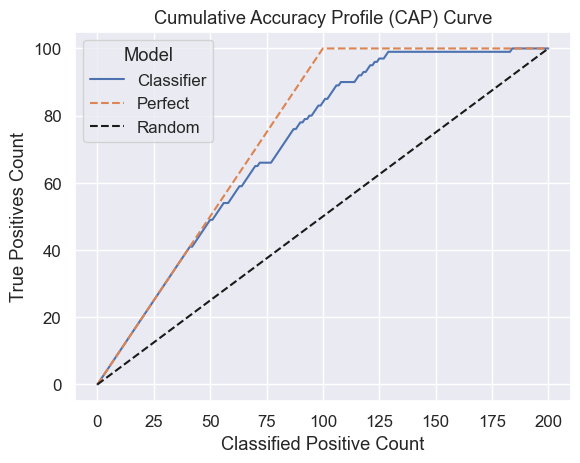

In [16]:
# cap curve for logistic regression
cap.plot_cap_curve(log_reg, X, y, method="predict_proba", normalised=False)

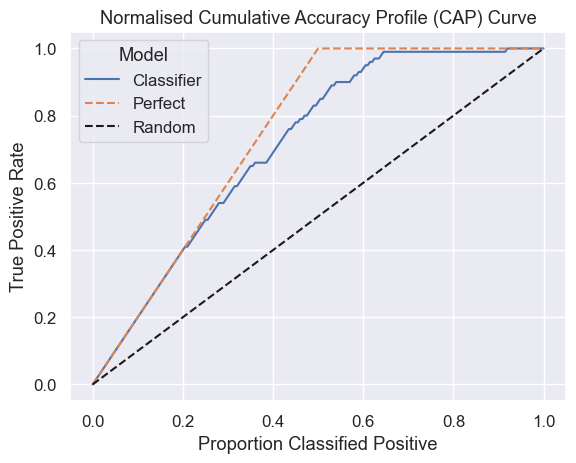

In [17]:
# normalised cap curve
cap.plot_cap_curve(log_reg, X, y, method="predict_proba", normalised=True)

### Accuracy Ratio

Let $A$ (resp. $B$) denote the area between the CAP curve of our classifier's (resp. of a perfect classifier) and the expected curve for a random classifier.

**Definition:** The *accuracy ratio* of our classifier is $A/B$.

#### Relationship with Gini Coefficient

**Proposition:** The accuracy ratio of a classifier equals Somers' D $D_{\mathbf{\hat{p}}\mathbf{y}}$ for $\mathbf{y}$ with respect to $\mathbf{\hat{p}}$.

We prove this in the case that the $\hat{p}_i$ are distinct.

*Proof:* Somers' D is invariant under permutations of the samples, so without loss of generality order the samples as $(\hat{p}_1, y_1), \ldots, (\hat{p}_n, y_n)$ with $\hat{p}_1 > \cdots > \hat{p}_n$. Let $n_+$ (resp. $n_-$) denote the number of positive (resp. negative) samples, so $n=n_+ + n_-$. We consider the un-normalised CAP curve, since clearly the ratio of areas is invariant under rescaling of the axes, so the $x$-axis goes from 0 to $n$ and the $y$-axis goes from 0 to $n_+$.

The result follows immediately from the following three claims:
1. if all 1s are before all 0s in $\mathbf{y}$ then $D_{\mathbf{\hat{p}}\mathbf{y}} = A/B$;
2. any transposition $10 \to 01$ in $\mathbf{y}$ changes $D_{\mathbf{\hat{p}}\mathbf{y}}$ and $A/B$ by the same amount; and
3. any ordering of $\mathbf{y}$ can be obtained from the state in (1) by the transpositions in (2).

First note that the area between the random curve and the $x$-axis is $\frac{1}{2}n_+n = \frac{1}{2}n_+(n_+ + n_-) = \frac{1}{2}(n_+^2+n_+n_-)$ and the area between the perfect curve and the $x$-axis is $\frac{1}{2}n_+^2 + n_+n_-$, so $B = \frac{1}{2}n_+n_-$. On the other hand, Kendall's $\tau$, $\tau(\mathbf{y},\mathbf{y})$, is equal to the number of pairs of unequal values in $\mathbf{y}$. This is simply the number of matchings between 1s and 0s, so $\tau(\mathbf{y},\mathbf{y}) = n_+n_-$.

Now consider (1). If all 1s are before all 0s in $\mathbf{y}$ then the classifier is perfect, so its curve coincides with the perfect curve and $A/B=1$. On the other hand, since $\mathbf{\hat{p}}$ and $\mathbf{y}$ are both in non-increasing order, $(\mathbf{\hat{p}}, \mathbf{y})$ has no discordant pairs and a pair is concordant if and only if one $y$-value is 1 and the other 0. So $\tau(\mathbf{\hat{p}},\mathbf{y})=n_+n_-=\tau(\mathbf{y},\mathbf{y})$ and $D_{\hat{p}y}=1$.

For (2), suppose that $\mathbf{y}$ is ordered such that $y_k=1$ and $y_{k+1}=0$ and let $\mathbf{y'}$ be the sequence obtained from $\mathbf{y}$ by swapping $y_k$ and $y_{k+1}$. If $c_i$ (resp. $c_i'$) is the number of $j\leq i$ such that $y_j=1$ (resp. $y_j'=1$) then $c_i=c_i'$ for $i\neq k$ and $c_k'=c_k-1$. So if $A$ (resp. $A'$) is the area between the old (resp. new) classifier's curve and the random curve, then $A'=A-1$ and hence

\begin{equation}
    \frac{A'}{B} = \frac{A - 1}{B} = \frac{A}{B} - \frac{2}{n_+n_-},
\end{equation}

since we already showed that $B = \frac{1}{2}n_+n_-$.

For Somers' D, swapping $y_k$ and $y_{k+1}$ simply reduces the number of concordant pairs in $(\mathbf{\hat{p}}, \mathbf{y})$ by 1 and increases the number of discordant pairs by 2. So

\begin{equation}
    D_{\mathbf{\hat{p}}\mathbf{y'}} 
        = \frac{\tau(\mathbf{\hat{p}}, \mathbf{y'})}{\tau(\mathbf{y}, \mathbf{y})}
        = \frac{\tau(\mathbf{\hat{p}}, \mathbf{y}) - 2}{\tau(\mathbf{y}, \mathbf{y})}
        = \frac{\tau(\mathbf{\hat{p}}, \mathbf{y})}{\tau(\mathbf{y}, \mathbf{y})} - \frac{2}{n_+n_-},
\end{equation}

since $\tau(\mathbf{\hat{p}}, \mathbf{\hat{p}})=n_+n_-$. Claim (2) is proved.

Claim (3) should be clear.

---

#### Example

We calculate the accuracy ratio and for the logistic regression model.

In [18]:
from scipy.integrate import trapezoid

# def area_under_classifier_cap_curve(classifier, X, y, method):
#     samples_count = len(y)
#     positive_samples_count = y.sum()

#     x_vals = np.arange(0, samples_count + 1)
    
#     classifier_cumulative_positive_outputs = cap.get_classifier_cumulative_positive_outputs(classifier, X, y, method)
#     random_cumulative_positive_outputs = np.linspace(0, positive_samples_count, samples_count + 1)
    
#     difference_in_cumulative_positive_outputs = classifier_cumulative_positive_outputs - random_cumulative_positive_outputs
    
#     area_between_classifier_and_random_cap_curves = 
    
#     area_under_classifier_cap_curve = trapezoid(y=classifier_cumulative_positive_outputs, x=x_vals)
#     area_under_random_cap_curve = trapezoid(y=random_cumulative_positive_outputs, x=x_vals)
    
#     area_between_classifier_and_random_cap_curves = area_under_classifier_cap_curve - area_under_random_cap_curve
    
    

# def get_accuracy_ratio(classifier, X, y, method):
#     samples_count = len(y)
#     positive_samples_count = y.sum()

#     x_vals = np.arange(0, samples_count + 1)

#     perfect_cumulative_positive_outputs = cap.get_perfect_cumulative_positive_outputs(y)
#     classifier_cumulative_positive_outputs = cap.get_classifier_cumulative_positive_outputs(classifier, X, y, method)
#     random_cumulative_positive_outputs = np.linspace(0, positive_samples_count, samples_count + 1)
    
#     area_under_perfect_cap_curve = trapezoid(y=perfect_cumulative_positive_outputs, x=x_vals)
#     area_under_classifier_cap_curve = trapezoid(y=classifier_cumulative_positive_outputs, x=x_vals)
#     area_under_random_cap_curve = trapezoid(y=random_cumulative_positive_outputs, x=x_vals)
    
#     accuracy_ratio = area_under_classifier_cap_curve - area_under_random_cap_curve
#     accuracy_ratio /= area_under_perfect_cap_curve - area_under_random_cap_curve
    
#     return accuracy_ratio

In [20]:
accuracy_ratio = cap.get_accuracy_ratio(log_reg, X, y, method="predict_proba")
print("Accuracy Ratio: {}".format(accuracy_ratio))

0.8556

In [ ]:
# compare with gini coefficient
y_prob = log_reg.predict_proba(X)[:, 1]
gini_coefficient = gini.gini_coefficient(y_pred=y_prob, y_true=y)

print("Gini Coefficient: {}".format(gini_coefficient))

In [ ]:
blah

## Receiving Operating Characteristic (ROC) Curve

Take the same set up as in the previous section. Recall that $\frac{k_+}{n_+}$ is the true positive rate of the classifier and note that $\frac{k_-}{n_-}$ is the false positive rate.

**Definition:** The *Receiver Operating Characteristic (ROC) Curve* is the curve that linearly interpolates the points $(k_-, k_+)$, taken over all threshold values. The *Normalised* ROC Curve interpolates the points $(\frac{k_-}{n_-}, \frac{k_+}{n_+})$.

Again, people use ROC curve to refer to the normalised ROC curve.

As with the CAP curve, we generally plot the ROC curve against that of perfect and random classifiers. The ROC curve of a perfect classifier goes vertically from $(0, 0)$ to $(0, n_+)$ and then horizontally from $(0, n_+)$ to $(n_-, n_+)$. The expected ROC curve of a random classifier is a straight line from $(0, 0)$ to $(n_-, n_+)$.

### Relationship with CAP Curve

Both the CAP and ROC curves are constructed out of the values $k_+$, $k_-$, and $k = k_+ + k_-$ at different thresholds. In fact the two curves differ by an invertible linear transformation.

Define $
T = \begin{pmatrix}
    1 & -1 \\
    0 & 1
\end{pmatrix}
$. This maps $(x, y)$ to $(x-y, y)$ and so maps $(k, k_+)$ to $(k_-, k_+)$. That is, it maps the CAP curve to the ROC curve (it maps the defining points to each other and sends interpolating straight lines to interpolating straight lines). Notice in particular that it sends the perfect and random curves to their counterparts. Moreover, $T$ is invertible with $
T^{-1} = \begin{pmatrix}
    1 & 1 \\
    0 & 1
\end{pmatrix}
$.

For reference, the linear transformations to pass between normalised curves are:

\begin{equation}
    T = \begin{pmatrix}
        \frac{n}{n_-} & -\frac{n_+}{n_-} \\
        0 & 1
    \end{pmatrix}, \qquad
    T^{-1} = \begin{pmatrix}
        \frac{n_-}{n} & \frac{n_+}{n} \\
        0 & 1
    \end{pmatrix}.
\end{equation}

In [ ]:
# map cap curve to roc curve
classifier = log_reg

# generate data for cap curves
samples_count = len(y)
positive_samples_count = y.sum()

cap_x = np.arange(0, samples_count + 1)

classifier_cap_y = cap.get_classifier_cumulative_positive_outputs(classifier, X, y, method="predict_proba")
perfect_cap_y = cap.get_perfect_cumulative_positive_outputs(y=y)
random_cap_y = np.linspace(0, positive_samples_count, samples_count + 1)

classifier_cap_values = np.c_[cap_x, classifier_cap_y]
perfect_cap_values = np.c_[cap_x, perfect_cap_y]
random_cap_values = np.c_[cap_x, random_cap_y]

# transform to roc curves
classifier_roc_values = cap.transform_cap_to_roc(classifier_cap_values)
perfect_roc_values = cap.transform_cap_to_roc(perfect_cap_values)
random_roc_values = cap.transform_cap_to_roc(random_cap_values)

# plot roc curves
fig, ax = plt.subplots()

ax.plot(classifier_roc_values[:, 0], classifier_cap_values[:, 1], label="Classifier")
ax.plot(perfect_roc_values[:, 0], perfect_cap_values[:, 1], "--", label="Perfect")
ax.plot(random_roc_values[:, 0], random_cap_values[:, 1], "k--", label="Random")

ax.set_title("Receiver Operating Characteristic (ROC) Curve")
ax.set_xlabel("False Positives Count")
ax.set_ylabel("True Positives Count")

ax.legend(title="Model");

### Area Under the Curve

**Definition:** The *Area Under the Curve* (*AUC* or *AUROC*) is the area under the normalised ROC curve.

The AUROC goes from 0 to 1 with 0 being an anti-perfect classifier, 1 a perfect classifier, and 0.5 a random classifier.

#### Relationship with Gini Coefficient

**Proposition:** We have $\text{Gini Coefficient} = 2 \cdot \text{AUROC} - 1$.

*Proof:* Recall that the Gini coefficient is equal to the accuracy ratio for the CAP curve. Since normalised CAP curves and ROC curves differ by an invertible linear transformation, the areas between the normalised ROC curves are equal to the areas between the corresponding CAP curves multiplied by $\lvert \text{det}(T)\rvert$, and the ratios of areas are equal. Since the area between the perfect and random normalised ROC curves is $\frac{1}{2}$ and the area under latter is $\frac{1}{2}$, we have

\begin{equation}
    \text{Accuracy Ratio} = \frac{\text{AUROC} - \frac{1}{2}}{\frac{1}{2}}.
\end{equation}

The result follows.

---

#### Example

In [ ]:
from scipy.integrate import trapezoid

trapezoid(y=classifier_cap_vals[:, 1], x=classifier_cap_vals[:, 0]) - trapezoid(y=random_cap_vals[:, 1], x=random_cap_vals[:, 0])

In [ ]:
trapezoid(y=classifier_roc_vals[:, 1], x=classifier_roc_vals[:, 0]) - trapezoid(y=random_roc_vals[:, 1], x=random_roc_vals[:, 0])